# 

In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax.scipy.special import logsumexp
import genjax
from genjax import grasp
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
console = genjax.pretty()

In [3]:
# from https://github.com/mattjj/svae/blob/master/experiments/gmm_svae_synth.py
def make_pinwheel_data(
    key, radial_std, tangential_std, num_classes, num_per_class, rate
):
    keys = jax.random.split(key, 2)
    rads = jnp.linspace(0, 2 * jnp.pi, num_classes, endpoint=False)

    features = jax.random.normal(keys[0], (num_classes * num_per_class, 2)) * jnp.array(
        [radial_std, tangential_std]
    )
    features = features.at[:, 0].add(1.0)
    labels = jnp.repeat(jnp.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * jnp.exp(features[:, 0])
    rotations = jnp.stack(
        [jnp.cos(angles), -jnp.sin(angles), jnp.sin(angles), jnp.cos(angles)]
    )
    rotations = jnp.reshape(rotations.T, (-1, 2, 2))

    return 10 * jax.random.permutation(
        keys[1], jnp.einsum("ti,tij->tj", features, rotations)
    )

500


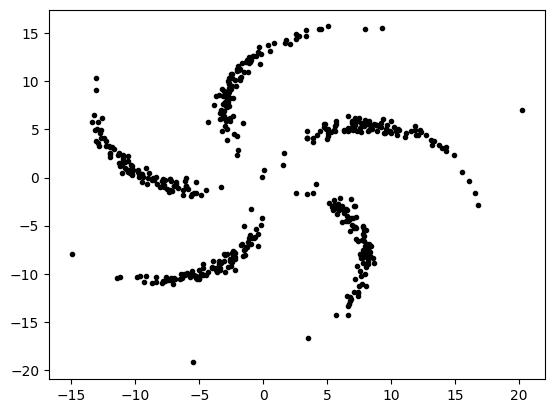

In [4]:
NUM_CLUSTERS = 5
POINTS_PER_CLUSTER = 100
N = NUM_CLUSTERS * POINTS_PER_CLUSTER
print(N)
pinwheel = make_pinwheel_data(
    jax.random.PRNGKey(0), 0.3, 0.05, NUM_CLUSTERS, POINTS_PER_CLUSTER, 0.25
)
plt.scatter(pinwheel[:, 0], pinwheel[:, 1], marker=".", c="black")

---

In [5]:
mlp = lambda x, ws: reduce(lambda z, w: jax.nn.leaky_relu(w @ z, 0.5), ws, x)
matsqr = lambda x: x.T @ x
key = jax.random.PRNGKey(0)

In [6]:
@genjax.gen
def model(params):
    logits, means, scales, mean_ws, scale_ws = params
    z = grasp.categorical_enum(logits) @ "z"
    cluster_mean = jax.lax.dynamic_index_in_dim(means, z, keepdims=False)
    cluster_scale = jax.lax.dynamic_index_in_dim(scales, z, keepdims=False)
    x = grasp.mv_normal_reparam(cluster_mean, matsqr(cluster_scale)) @ "x"
    point_mean = mlp(x, mean_ws)
    point_scale = mlp(x, scale_ws).reshape(2, 2)
    grasp.mv_normal_reparam(point_mean, matsqr(point_scale)) @ "y"

In [7]:
def make_model_weights(key):
    keys = jax.random.split(key, 8)
    return (
        jnp.ones(NUM_CLUSTERS), # logits
        jnp.zeros((NUM_CLUSTERS, 2)), # means
        jnp.tile(jnp.eye(2), (NUM_CLUSTERS, 1)).reshape(NUM_CLUSTERS, 2, 2), # scales
        tuple(map(lambda a: a * 1, (
            jax.random.uniform(keys[0], (10, 2)),
            jax.random.uniform(keys[1], (10, 10)),
            jax.random.uniform(keys[2], (10, 10)),
            jax.random.uniform(keys[3], (2, 10)),
        ))), # mean_ws
        tuple(map(lambda a: a * 0.5, (
            jax.random.uniform(keys[4], (10, 2)),
            jax.random.uniform(keys[5], (10, 10)),
            jax.random.uniform(keys[6], (10, 10)),
            jax.random.uniform(keys[7], (4, 10)),
        ))) # scale_ws
)
model_params = make_model_weights(key)

In [8]:
logits, means, scales, mean_ws, scale_ws = model_params
z = 0
key = jax.random.split(key)[0]
cluster_mean = jax.lax.dynamic_index_in_dim(means, z, keepdims=False)
cluster_scale = jax.lax.dynamic_index_in_dim(scales, z, keepdims=False)
x = grasp.mv_normal_reparam.simulate(key, (cluster_mean, matsqr(cluster_scale))).value
x, mlp(x, mean_ws), matsqr(mlp(x, scale_ws).reshape(2, 2))


(
    Array([-0.04950034, -0.711568  ], dtype=float32),
    Array([-2.8799644, -3.2433472], dtype=float32),
    Array([[0.08411495, 0.10981131],
       [0.10981131, 0.14400752]], dtype=float32)
)

In [9]:
ch = model.simulate(key, (model_params,)).strip()
key = jax.random.split(key)[0]
ch['z'], ch['x'], ch['y']


(
    Array(4, dtype=int32),
    Array([-0.89105326, -0.66184473], dtype=float32),
    Array([-5.76409  , -6.2452426], dtype=float32)
)

In [10]:
@genjax.gen
def variational_family(params, data):
    mean_ws, scale_ws, cat_ws = params
    cluster_mean = mlp(data["y"], mean_ws)
    cluster_scale = mlp(data["y"],scale_ws).reshape(2, 2)
    x = grasp.mv_normal_reparam(cluster_mean, matsqr(cluster_scale)) @ "x"
    z = grasp.categorical_enum(mlp(x, cat_ws)) @ "z"

In [11]:
def make_vf_weights(key):
    keys = jax.random.split(key, 8)
    return (
        (
            jax.random.uniform(keys[0], (10, 2)),
            jax.random.uniform(keys[1], (10, 10)),
            jax.random.uniform(keys[2], (10, 10)),
            jax.random.uniform(keys[3], (2, 10)),
        ), # mean_ws
        (
            jax.random.uniform(keys[4], (10, 2)),
            jax.random.uniform(keys[5], (10, 10)),
            jax.random.uniform(keys[6], (10, 10)),
            jax.random.uniform(keys[7], (4, 10)),
        ), # scale_ws
        (
            jax.random.uniform(keys[8], (10, 2)),
            jax.random.uniform(keys[9], (10, 10)),
            jax.random.uniform(keys[10], (10, 10)),
            jax.random.uniform(keys[11], (NUM_CLUSTERS, 10)),
        ) # cat_ws
    )
vf_params0 = make_vf_weights(key)
vf_params = vf_params0

In [12]:
pinwheel_data = genjax.choice_map({"y": pinwheel[0, :]})
key = jax.random.split(key)[0]
ch = variational_family.simulate(key, (vf_params, pinwheel_data)).strip()
ch['x'], ch['z']

(Array([12.848938, 37.530582], dtype=float32), Array(2, dtype=int32))

In [13]:
def make_batched_loss_and_grad(model, vf):
    def loss_and_grad(key, datapoint, model_params, vf_params):
        data = genjax.choice_map({"y": datapoint})
        objective = grasp.elbo(model, vf, data)
        loss, ((model_grad,), (vf_grad, data)) = objective.value_and_grad_estimate(
            key, ((model_params,), (vf_params, data))
        )
        return (vf_grad, model_grad), loss

    def batched_loss_and_grad(key, batch, model_params, vf_params):
        mapped_loss_and_grad = jax.vmap(loss_and_grad, in_axes=(0, 0, None, None))
        keys = jax.random.split(key, len(batch))
        (vf_grads, model_grads), losses = mapped_loss_and_grad(keys, batch,
                                                               model_params, vf_params)
        vf_grad = jtu.tree_map(lambda a: a.mean(axis=0), vf_grads)
        model_grad = jtu.tree_map(lambda a: a.mean(axis=0), model_grads)
        return vf_grad, model_grad, losses.mean()

    return batched_loss_and_grad

In [14]:
batched_loss_and_grad = jax.jit(make_batched_loss_and_grad(model, variational_family))

In [15]:
BATCH_SIZE = 50
NUM_EPOCHS = 200
LR = 1e-10
assert N % BATCH_SIZE == 0
epoch_losses = []
for epoch in range(NUM_EPOCHS):
    perm = jax.random.permutation(key, pinwheel)
    losses = []
    for i in range(N // BATCH_SIZE):
        batch = perm[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        vf_grad, model_grad, loss = batched_loss_and_grad(
            key, batch, model_params, vf_params)
        vf_params = jtu.tree_map(lambda p, g: p - LR * g, vf_params, vf_grad)
        model_params = jtu.tree_map(lambda p, g: p - LR * g, model_params, model_grad)
        key = jax.random.split(key)[0]
        losses.append(loss)
    epoch_losses.append(jnp.array(losses).mean())
    print(f'Epoch {epoch} loss: {epoch_losses[-1]}')

Epoch 0 loss: -817974.1875
Epoch 1 loss: -877552.1875
Epoch 2 loss: -674474.4375
Epoch 3 loss: -814066.4375
Epoch 4 loss: -694059.125
Epoch 5 loss: -652902.75
Epoch 6 loss: -776948.4375
Epoch 7 loss: -714215.625
Epoch 8 loss: -667918.25
Epoch 9 loss: -703084.6875
Epoch 10 loss: -650757.4375
Epoch 11 loss: -657977.0
Epoch 12 loss: -719689.0
Epoch 13 loss: -829595.125
Epoch 14 loss: -928045.125
Epoch 15 loss: -748170.25
Epoch 16 loss: -959399.625
Epoch 17 loss: -1281121.0
Epoch 18 loss: -1374879.5
Epoch 19 loss: -1018434.8125
Epoch 20 loss: -1414904.875
Epoch 21 loss: -1231512.125
Epoch 22 loss: -1604251.875
Epoch 23 loss: -1180544.25
Epoch 24 loss: -1376196.75
Epoch 25 loss: -1162687.25
Epoch 26 loss: -1349479.0
Epoch 27 loss: -1208394.25
Epoch 28 loss: -1219957.25
Epoch 29 loss: -1635080.625
Epoch 30 loss: -1206029.75
Epoch 31 loss: -1137790.5
Epoch 32 loss: -1347896.875
Epoch 33 loss: -1147003.5
Epoch 34 loss: -1092010.875
Epoch 35 loss: -1559951.375
Epoch 36 loss: -1251360.0
Epoch 37

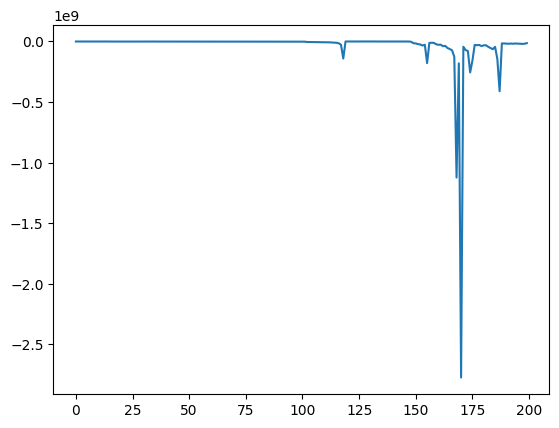

In [17]:
plt.plot(epoch_losses)